<a href="https://colab.research.google.com/github/vifirsanova/nlp-course/blob/main/tutorial_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Рекуррентные нейросети

### Интуиция

**Рекуррентная нейросеть**

- Научить модель *запоминать* последовательности, чтобы:

 - вывести информацию о позициях токенов и учитывать порядок расположения токенов

   *Ср. 'A man who hated a snake' vs. 'A snake who hated a man'*

 - натренировать модель кодировать и декодировать длинные последовательности, чтобы выявлять зависимости в сложных рекурсивных конструкциях

    *'A man who hated snakes and never saw snowflakes, who had a little cat and a plenty of hats, was bitten by a mad man on a shiny afternoon.' --> а теперь выполним разметку синтаксиса...*

**Задачи для RNN**

- Генерация текста
- Машинный перевод
- Анализ временных рядов: https://habr.com/ru/companies/otus/articles/732080/
- ELMO: https://github.com/PrashantRanjan09/Elmo-Tutorial

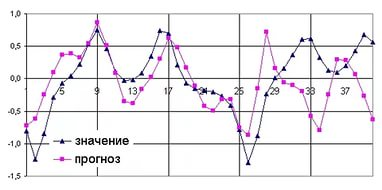

> **Выход RNN на каждом шаге зависит от текущего входа и предыдущего состояния.**

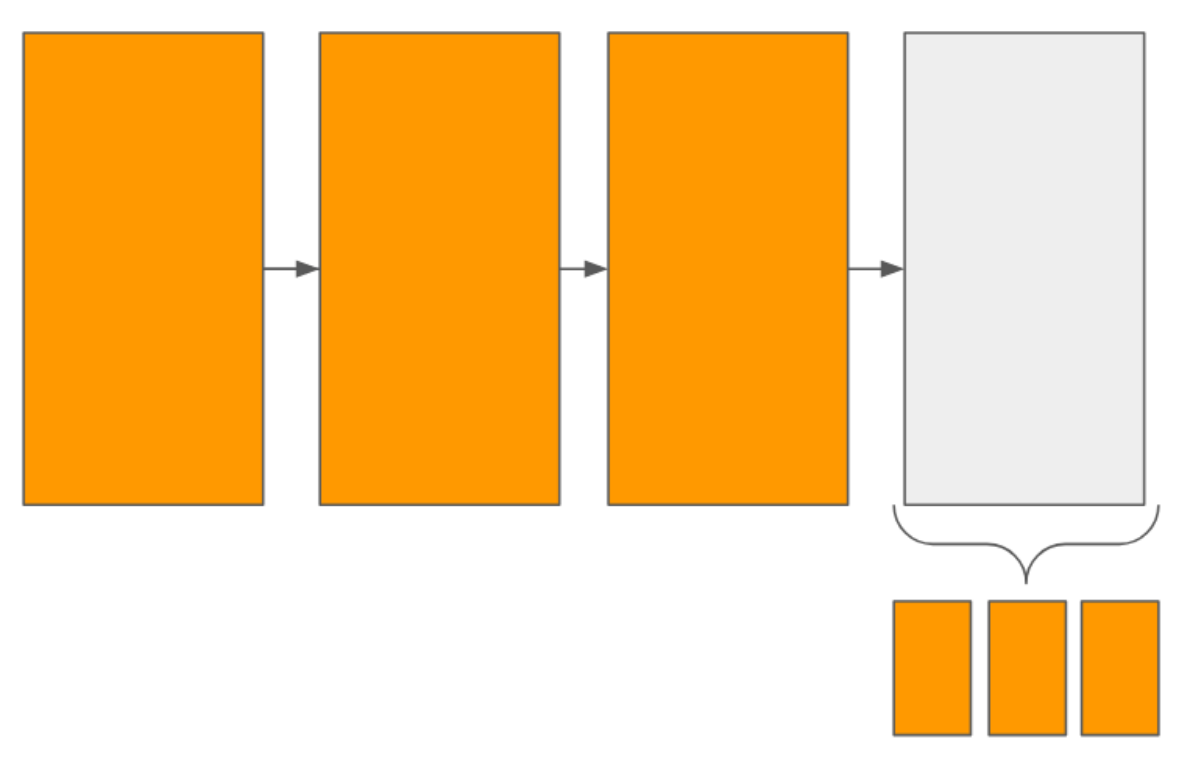

Long Short-Term Memory (LSTM)

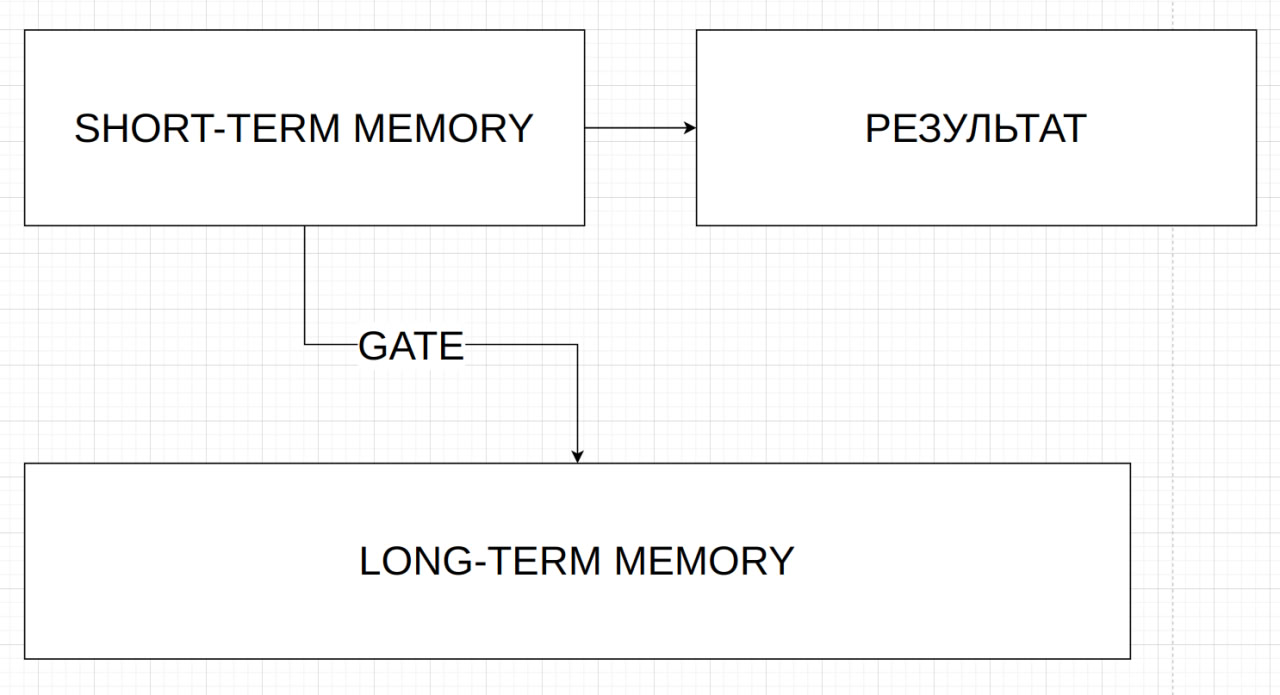

### Ванильная RNN

Что происходит в одной ячейке RNN (скрытое состояние на текущем шаге *t*):

$$ h_t = \sigma( Wx_t + Vh_{t-1}  + b) $$

- $x_t$ - входные данные на шаге *t*

    *Что такое шаг t?*

    *Допустим, мы моделируем предложение 'A cat is on the mat'.*

    *Мы последовательно моделируем следующие зависимости:*

    *P(\<start> | A)*

    *$x_t$ = A*

    *P(\<start> A | cat)*

    *$x_t$ = cat*

    *P(\<start> A cat | is)*

    *$x_t$ = is*

    *P(\<start> A cat is | on)*

    *$x_t$ = on*

    *Этот процесс называется* ***causal language modeling***.

    *Вспомним принцип Маркова: https://en.wikipedia.org/wiki/Markov%27s_principle.*

    *Обратите внимание на способ подготовки данных:*

    ```
    X = [[3000],
        [3000, 3001],
        [3000, 3001, 36],
        [3000, 3001, 36, 133],
        [3000, 3001, 36, 133, 5366],
        [110],
        [110, 30],
        [110, 30, 1274],
        [110, 30, 1274, 336],
        [110, 30, 1274, 336, 17]]

    y = [3001, 36, 133, 5366, 1785, 30, 1274, 336, 17, 3842])
    ```

##### Загрузка библиотек

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

##### Загрузка данных

In [ ]:
!pip install datasets -q

from datasets import load_dataset
dataset = load_dataset("baptle/financial_headlines_market_based")

README.md:   0%|          | 0.00/420 [00:00<?, ?B/s]

to_hg_data.csv:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8142 [00:00<?, ? examples/s]

Нам нужны только тексты заголовков новостей

In [ ]:
dataset['train']['Title'][:10]

['Global Stocks and Commodities Rally on First Trading Day of 2010',
 'Dollar Slumps Amid Worldwide Manufacturing Improvement',
 'Oil Prices Surge Above $81 a Barrel Due to U.S. Cold Weather',
 'S&P 500 Sees 1.6 Percent Increase, Hits 15-Month High',
 "Argentina's Merval Index Reaches Record High, Brazil's Bovespa Surpasses 70,000",
 'Natural Gas and Crude Oil Prices Jump Amid U.S. Cold Snap',
 'Gold and Copper Prices Rise, with Copper Hitting 16-Month High',
 'U.S. Manufacturing Index Reaches Highest Level in Over Three Years',
 ' Exxon Mobil Corp. and Chevron Corp. Lead Gains in U.S. Energy Shares',
 ' Intel Corp. Shares Rally After Upgrade by Robert W. Baird & Co.']

Оставим первые 10000, чтобы упростить задачу

In [ ]:
data = dataset['train']['Title'][:1000]

##### Подготовка данных

In [ ]:
# Инициализируем токенизатор
tokenizer = Tokenizer()

# Обучаем токенизатор на заголовках
tokenizer.fit_on_texts(data)

# Преобразуем заголовки в последовательности чисел
sequences = tokenizer.texts_to_sequences(data)

# Создаем входные и выходные данные
X = []
y = []
for seq in sequences:
    for i in range(1, len(seq)):
        X.append(seq[:i])
        y.append(seq[i])

Паддинг:

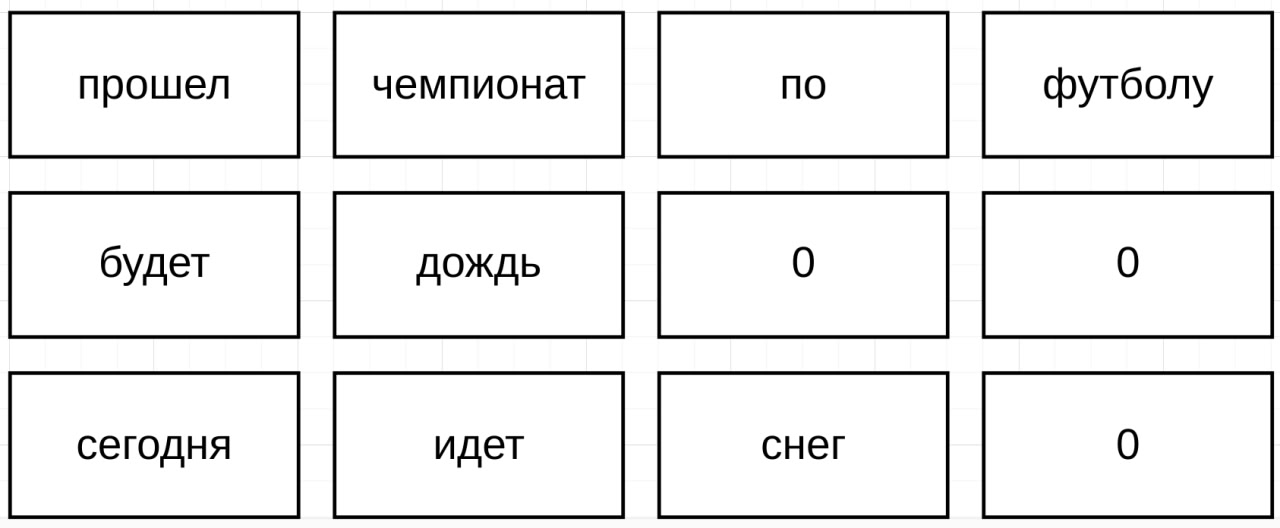

Посмотрим на наши вектора

**Вопрос:** что кодируют эти числа? Какие значения попадают в y, а что хранится в X'ах?

In [ ]:
X[:10], y[:10]

([[71],
  [71, 9],
  [71, 9, 2],
  [71, 9, 2, 55],
  [71, 9, 2, 55, 35],
  [71, 9, 2, 55, 35, 12],
  [71, 9, 2, 55, 35, 12, 117],
  [71, 9, 2, 55, 35, 12, 117, 178],
  [71, 9, 2, 55, 35, 12, 117, 178, 49],
  [71, 9, 2, 55, 35, 12, 117, 178, 49, 38]],
 [9, 2, 55, 35, 12, 117, 178, 49, 38, 248])

##### Создание модели

$$ h_t = \sigma( Wx_t + Vh_{t-1}  + b) $$

- $W$ и $V$ - это обучаемые параметры

  - *Повторение: какие параметры являются обучаемыми, а какие - необучаемыми?*

  - $W$ отвечает на передачу информации от входного слоя к выходному

  - $V$ отвечает за передачу информации внутри скрытых слоев

- $b$ - это bias

  - *Повторение: что такое bias и зачем он используется?*

- $\sigma$ - нелинейность, тип функции, к которой применяются вычисленные параметры


In [ ]:
# Преобразуем списки в массивы numpy
X = np.asarray(X, dtype="object")
y = np.array(y)

# Дополняем последовательности до одинаковой длины
X = pad_sequences(X)

# Преобразуем y в one-hot encoding
y = tf.keras.utils.to_categorical(y, num_classes=len(tokenizer.word_index) + 1)

##### Обучение модели

Архитектура модели:

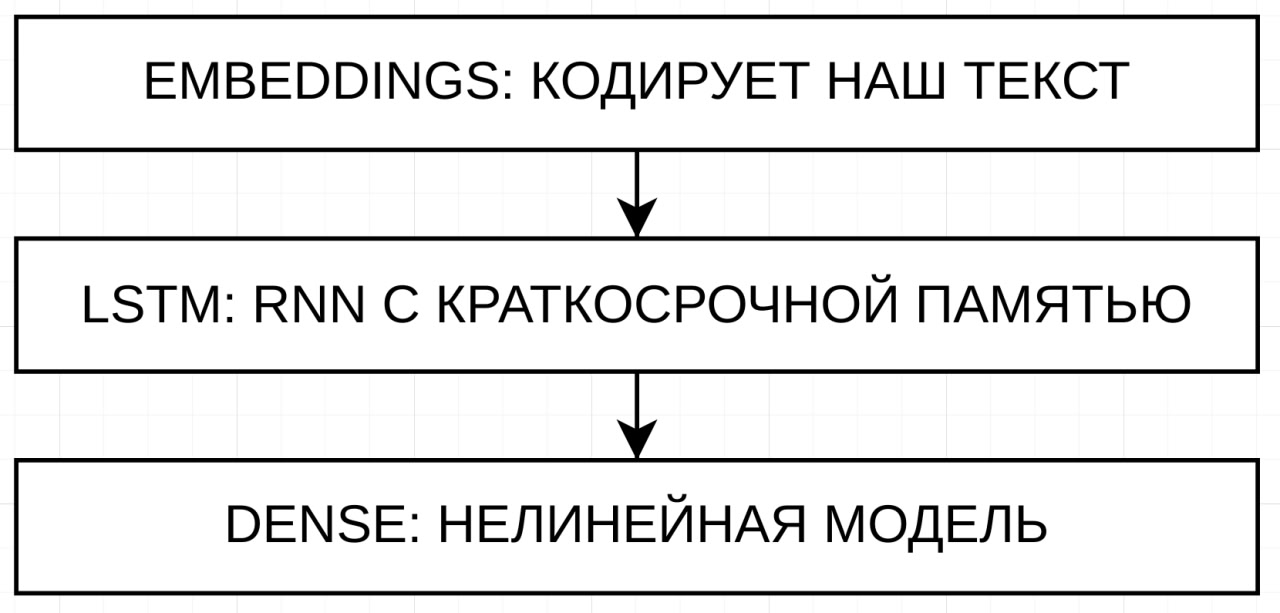

In [ ]:
# Создаем модель
model = Sequential()

# Добавляем слой Embedding
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X.shape[1]))

# Добавляем слой LSTM
model.add(LSTM(150, return_sequences=False))

# Добавляем полносвязный слой
model.add(Dense(len(tokenizer.word_index) + 1, activation='softmax'))

# Компилируем модель
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Выводим информацию о модели
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Обучаем модель
history = model.fit(X, y, epochs=10, batch_size=1, validation_split=0.2)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.0224 - loss: 6.8060 - val_accuracy: 0.0580 - val_loss: 6.3903
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.0428 - loss: 6.0619 - val_accuracy: 0.0650 - val_loss: 6.2829
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.0523 - loss: 5.7805 - val_accuracy: 0.0656 - val_loss: 6.2046
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.0815 - loss: 5.6387 - val_accuracy: 0.0861 - val_loss: 6.1230
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.0987 - loss: 5.4061 - val_accuracy: 0.0984 - val_loss: 6.0461
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.1274 - loss: 5.1108 - val_accuracy: 0.1119 - val_loss: 5.9460
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.1406 - loss: 4.9456 - val_accuracy: 0.1242 - val_loss: 5.8972
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.1794 - loss: 4.6671 - val_

Обновим саммари модели

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 16, 100)             │         153,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 150)                 │         150,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1534)                │         231,634 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,606,904 (6.13 MB)

 Trainable params: 535,634 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,071,270 (4.09 MB)

Тестируем

In [ ]:
# Функция для генерации текста
def generate_text(seed_text, next_words, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

# Генерируем новый заголовок
generated_text = generate_text("Dollar", 2, X.shape[1])
print(generated_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Dollar index drops


Сохраняем

In [ ]:
# Сохраняем модель
model.save('news_headline_generator.keras')

### Метрики оценки для моделирования языка

Для оценки качества моделирования языка (генерации текста) испольуется метрика **перплексия**

Перплексия - это "инвертированное" правдоподобие последовательности

Допустим, мы обучаем модель для генерации текстов. Чем выше правдоподобие этих текстов (чем сильнее они похожи на тексты из золотой выборки), тем ниже их перплексия

$$\text{PPL}(X) = \exp \left\{ {-\frac{1}{t}\sum_i^t \log p_\theta (x_i|x_{<i}) } \right\}$$

- $\log p_\theta (x_i|x_{<i})$ - правдоподобие i-того токена, обусловленного предшествующими токенами $x_{<i}$ (оцениваем вероятность встречаемости данного токена с предшествующими)

**Интуиция:** оценка способности модели предсказать последовательность и взаимное расположение в контекстах равномерно распределенного набора токенов

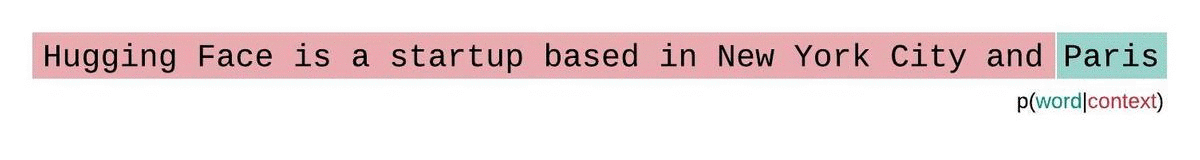

Обычно перплексия считается для заданного контекстного окна, а не для корпуса целиком. Мы добавляем параметр *k*, который считает правдоподобие и перплексию только для токенов в диапазоне $[x_{-1}, x_{k-1}]$:

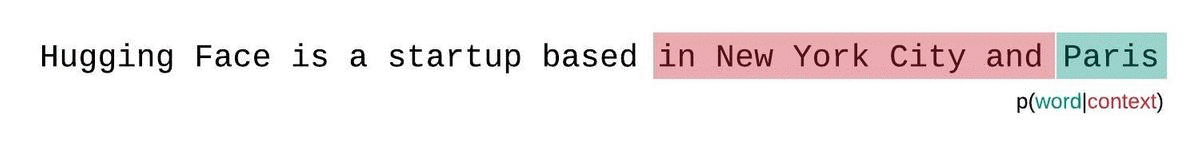

Как это реализовано в HuggingFace: https://colab.research.google.com/github/huggingface/notebooks/blob/main/transformers_doc/en/pytorch/perplexity.ipynb